<a href="https://colab.research.google.com/github/LuccaPaiva/portfolio/blob/main/letterboxd/letterboxd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:

#import letterboxd
#utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval

#html
import requests
from bs4 import BeautifulSoup
import json

#gsheets
from google.colab import auth
from gspread_dataframe import set_with_dataframe
import gspread
import gspread_dataframe as gdf
from google.auth import default

#map
from matplotlib.patches import Polygon
!pip install basemap
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.cm as cm

## Auth

In [58]:
#nome_de_usuario = "BeyBlade"
auth.authenticate_user()
creds, _ = default()

Setting Spreadsheet

In [59]:
gc = gspread.authorize(creds)
lbxd_spreadsheet = gc.open("letterboxd")

## Data

### Import

In [60]:
def get_diary():
  diary_worksheet = lbxd_spreadsheet.worksheet("diary")
  diary = pd.DataFrame(diary_worksheet.get_all_records())
  diary.rename(columns={'Letterboxd URI': 'Review URI'}, inplace=True)
  #diary.rename(columns={'Date': 'Log Date'}, inplace=True)

  return diary

In [61]:
def get_watched():
  watched_worksheet = lbxd_spreadsheet.worksheet("watched")
  watched = pd.DataFrame(watched_worksheet.get_all_records())
  #watched.rename(columns={'Date': 'Date'}, inplace=True)
  return watched

## Data Manipulation

In [62]:
genre_retirieved = True
try:
  data_worksheet = lbxd_spreadsheet.worksheet("data")
  merged_df = pd.DataFrame(data_worksheet.get_all_records())
  country_retrieved = True
except:
  diary = get_diary()
  watched = get_watched()
  merged_df = pd.merge(diary, watched, on=['Name', "Year"])
  country_retrieved = False
  genre_retirieved = False
merged_df, country_retrieved

(         Date_x                             Name  Year  \
 0    2020-08-31                     Palm Springs  2020   
 1    2020-08-31                         Sertânia  2019   
 2    2020-08-31                          Arrival  2016   
 3    2020-08-31                      Da 5 Bloods  2020   
 4    2020-08-31                       Game Night  2018   
 ..          ...                              ...   ...   
 387  2024-05-21                      Challengers  2024   
 388  2024-05-21  It's a Mad, Mad, Mad, Mad World  1963   
 389  2024-05-30                     The Hot Rock  1972   
 390  2024-06-01                       La Chimera  2023   
 391  2024-06-05                        Barbarian  2022   
 
                  Review URI Rating Rewatch                   Tags  \
 0    https://boxd.it/1kuvvH     35     Yes              fun, leve   
 1    https://boxd.it/1ktSDd      4                       denso, ?   
 2    https://boxd.it/1ktS1X      5                                  
 3    http

In [63]:
def get_movie_country(movie_url = "https://boxd.it/vzVi"):
  response = requests.get(movie_url)
  html_content = response.content
  soup = BeautifulSoup(html_content, "html.parser")
  target_element = soup.find(id="tabbed-content")
  target_elements = target_element.select("a[href*='/films/country/']")
  country = []
  for element in target_elements:
    country.append(element.text)
  return country

print(get_movie_country())

['France', 'Italy', 'Switzerland', 'Turkey']


In [64]:
def get_movie_genres(movie_url = "https://boxd.it/vzVi"):
  response = requests.get(movie_url)
  html_content = response.content
  soup = BeautifulSoup(html_content, "html.parser")
  target_element = soup.find(id="tabbed-content")
  target_elements = target_element.select("a[href*='/films/genre/']")
  genres = []
  for element in target_elements:
    genres.append(element.text)
  return genres

print(get_movie_genres())

['Comedy', 'Drama', 'Adventure', 'History', 'Fantasy']


In [65]:
merged_df["Letterboxd URI"]

0      https://boxd.it/lCXQ
1      https://boxd.it/lUhS
2      https://boxd.it/aNGk
3      https://boxd.it/lnXw
4      https://boxd.it/fRtu
               ...         
387    https://boxd.it/zld0
388    https://boxd.it/1TvO
389     https://boxd.it/O2U
390    https://boxd.it/vzVi
391    https://boxd.it/yohi
Name: Letterboxd URI, Length: 392, dtype: object

In [66]:
if not country_retrieved:
  movie_countries = []

  # Loop through each movie URL in the dataframe
  for movie_url in merged_df['Letterboxd URI']:
    # Get the countries for the current movie
    countries = get_movie_country(movie_url)
    # Append the countries to the list
    movie_countries.append(countries)

  # Add a new column named "Country" to the dataframe
  merged_df['Country'] = movie_countries

  data_worksheet = lbxd_spreadsheet.worksheet("data")
  set_with_dataframe(worksheet=data_worksheet, dataframe=merged_df, include_index=False, include_column_header=True, resize=True)

  print(merged_df)

if not genre_retirieved:
  movie_genres = []

  # Loop through each movie URL in the dataframe
  for movie_url in merged_df['Letterboxd URI']:
    # Get the countries for the current movie
    try:
      genres = get_movie_genres(movie_url)
      movie_genres.append(genres)
    except:
      print(f"FAILED for {movie_url}")
      movie_genres.append("")
  # Add a new column named "Country" to the dataframe
  merged_df['Genres'] = movie_genres

if not country_retrieved or not genre_retirieved:
  data_worksheet = lbxd_spreadsheet.worksheet("data")
  set_with_dataframe(worksheet=data_worksheet, dataframe=merged_df, include_index=False, include_column_header=True, resize=True)

  merged_df

## Data Visualization

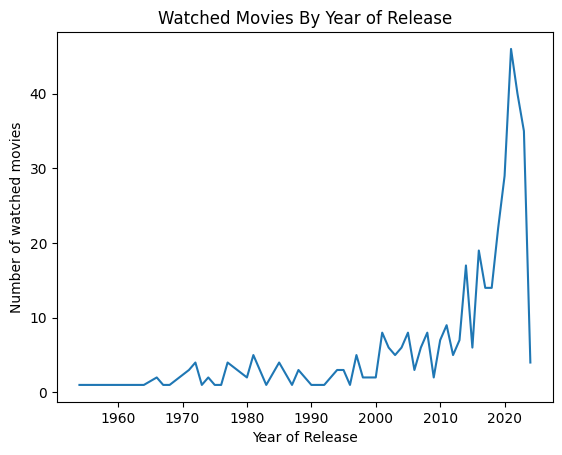

In [67]:
movie_by_year = merged_df['Year'].value_counts().sort_index()

fig = plt.figure()
plt.plot(movie_by_year)
plt.title("Watched Movies By Year of Release")
plt.xlabel("Year of Release")
plt.ylabel("Number of watched movies")
plt.show()

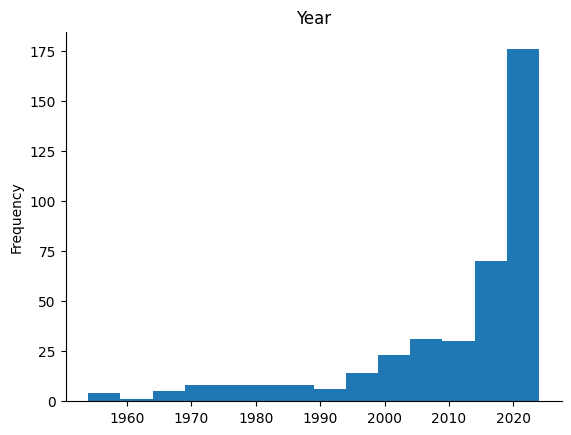

In [68]:
merged_df['Year'].plot(kind='hist', title='Year', bins=range(min(merged_df['Year']), max(merged_df['Year'])+1, 5))
plt.gca().spines[['top', 'right']].set_visible(False)

In [69]:
merged_df['Country'], merged_df['Genres']

(0                                           ['USA']
 1                                        ['Brazil']
 2                                           ['USA']
 3                                           ['USA']
 4                                           ['USA']
                            ...                     
 387                                ['Italy', 'USA']
 388                                         ['USA']
 389                                         ['USA']
 390    ['France', 'Italy', 'Switzerland', 'Turkey']
 391                                         ['USA']
 Name: Country, Length: 392, dtype: object,
 0               ['Romance', 'Science Fiction', 'Comedy']
 1                        ['History', 'Western', 'Drama']
 2                ['Science Fiction', 'Mystery', 'Drama']
 3                                       ['Drama', 'War']
 4                         ['Crime', 'Mystery', 'Comedy']
                              ...                        
 387                     

In [92]:
def movie_count(tag):
  movie_count = {}
  for collection in merged_df[tag]:
    try:
      c = literal_eval(collection)  # Use literal_eval if it's a string
      for item in c:
        if item in movie_count:
          movie_count[item] += 1
        else:
          movie_count[item] = 1
    except:
      continue

  return movie_count

def movie_count_country(tag):
  movie_count = {}
  for collection in merged_df[tag]:
    c = literal_eval(collection)  # Use literal_eval if it's a string

    for item in c:
        if item in movie_count:
          movie_count[item] += 1
        else:
          movie_count[item] = 1
  return movie_count

movie_count_by_country = movie_count_country('Country')
movie_count_by_genre = movie_count('Genres')
movie_count_by_country, movie_count_by_genre


({'USA': 291,
  'Brazil': 16,
  'Japan': 31,
  'UK': 49,
  'China': 16,
  'Hong Kong': 18,
  'Indonesia': 2,
  'Canada': 11,
  'Poland': 3,
  'South Korea': 6,
  'Thailand': 1,
  'Netherlands': 3,
  'Singapore': 2,
  'New Zealand': 3,
  'Australia': 6,
  'France': 21,
  'Malaysia': 1,
  'Portugal': 1,
  'Greece': 4,
  'Ireland': 7,
  'Taiwan': 1,
  'Denmark': 10,
  'Sweden': 7,
  'Spain': 4,
  'Austria': 1,
  'Germany': 13,
  'Italy': 8,
  'Belgium': 5,
  'Finland': 2,
  'Mexico': 2,
  'Switzerland': 5,
  'Norway': 1,
  'Chile': 2,
  'Argentina': 2,
  'India': 2,
  'USSR': 1,
  'Turkey': 2,
  'Luxembourg': 2,
  'Algeria': 1,
  'Albania': 1,
  'Kosovo': 1,
  'North Macedonia': 1,
  'Czechoslovakia': 1,
  'United Arab Emirates': 1},
 {'Romance': 32,
  'Science Fiction': 58,
  'Comedy': 142,
  'History': 19,
  'Western': 2,
  'Drama': 138,
  'Mystery': 39,
  'War': 9,
  'Crime': 48,
  'Family': 66,
  'Animation': 94,
  'Adventure': 107,
  'Fantasy': 82,
  'Action': 96,
  'Thriller': 61,
 

In [71]:
countries = list(movie_count_by_country.keys())

# Convert the dictionary to a DataFrame
df_movie_count = pd.DataFrame({
    'name': countries,
    'movie_count': list(movie_count_by_country.values())
})
df_movie_count = df_movie_count.sort_values(by='movie_count', ascending=False)

df_movie_count.loc[df_movie_count["name"] == "USA", "name"] = "United States of America"

df_movie_count.loc[df_movie_count["name"] == "UK", "name"] = "United Kingdom"

df_movie_count.head()

,name,movie_count
0,United States of America,291
3,United Kingdom,49
2,Japan,31
15,France,21
5,Hong Kong,18


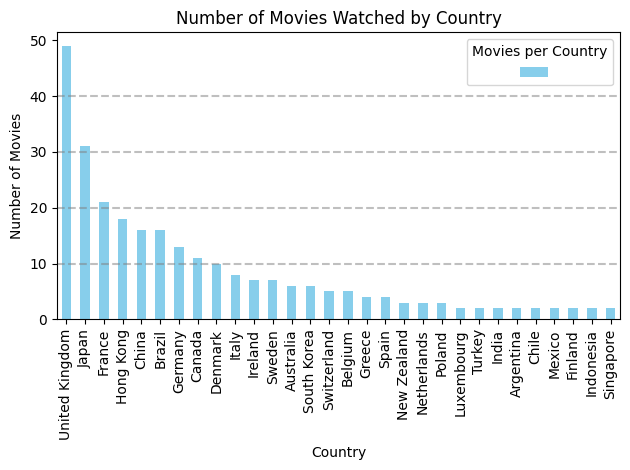

,name,movie_count
3,United Kingdom,49
2,Japan,31
15,France,21
5,Hong Kong,18
4,China,16


In [77]:
# Plot the bar chart
no_USA = df_movie_count.iloc[1:]
no_USA = no_USA[no_USA["movie_count"] > 1]
no_USA.plot(kind='bar', x='name', color='skyblue')

# Add a title and axis labels
plt.title('Number of Movies Watched by Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.legend(title="Movies per Country", labels=["", "number of movies"])
plt.tight_layout()
for y in range(10, 50, 10):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()
no_USA.head()

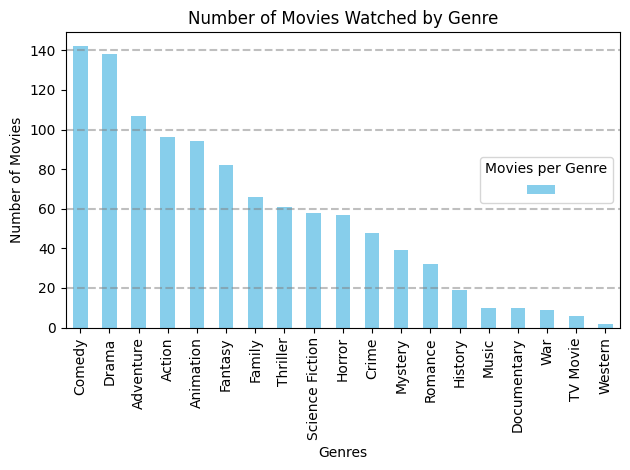

,name,movie_count
3,United Kingdom,49
2,Japan,31
15,France,21
5,Hong Kong,18
4,China,16


In [98]:
genres = list(movie_count_by_genre.keys())

# Convert the dictionary to a DataFrame
df_genre_count = pd.DataFrame({
    'name': genres,
    'movie_count': list(movie_count_by_genre.values())
})
df_genre_count = df_genre_count.sort_values(by='movie_count', ascending=False)

aux = df_genre_count[df_genre_count["movie_count"] > 1]
aux.plot(kind='bar', x='name', color='skyblue')

# Add a title and axis labels
plt.title('Number of Movies Watched by Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.legend(title="Movies per Genre", labels=["", "number of movies"])
plt.tight_layout()
for y in range(20, 141, 40):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()
no_USA.head()

### Mapa

In [78]:
#Read the world data and show the header
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(), world.shape

<ipython-input-78-af676962e209>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(       pop_est      continent                      name iso_a3  gdp_md_est  \
 0     889953.0        Oceania                      Fiji    FJI        5496   
 1   58005463.0         Africa                  Tanzania    TZA       63177   
 2     603253.0         Africa                 W. Sahara    ESH         907   
 3   37589262.0  North America                    Canada    CAN     1736425   
 4  328239523.0  North America  United States of America    USA    21433226   
 
                                             geometry  
 0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
 1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
 2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
 3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
 4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  ,
 (177, 6))

<ipython-input-79-86ced4ad56bc>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


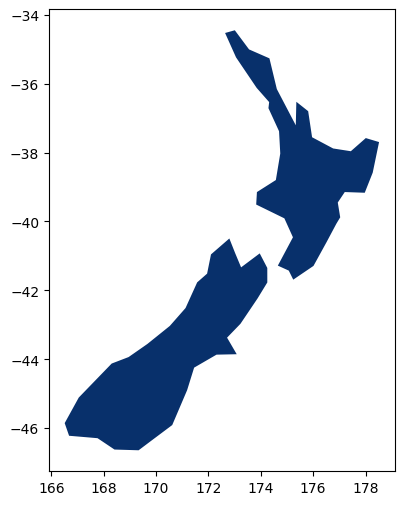

In [79]:
#Use pyplot (plt) to plot a country map such as New Zealand
fig, ax_nz = plt.subplots(figsize=(8,6))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "New Zealand"].plot(cmap='Blues_r', ax=ax_nz)
plt.show()

In [80]:
test = pd.merge(world, df_movie_count, on=['name'], how='left')
test['movie_count'] = test['movie_count'].fillna(0)
test.loc[test["name"] == "United States of America", "movie_count"] = 49
test = test[test["movie_count"] > 0]
test = test.sort_values(by='movie_count', ascending=False)
test[["name", "movie_count"]]

,name,movie_count
4,United States of America,49.0
143,United Kingdom,49.0
155,Japan,31.0
43,France,21.0
139,China,16.0
29,Brazil,16.0
121,Germany,13.0
3,Canada,11.0
142,Denmark,10.0
141,Italy,8.0


<Axes: >

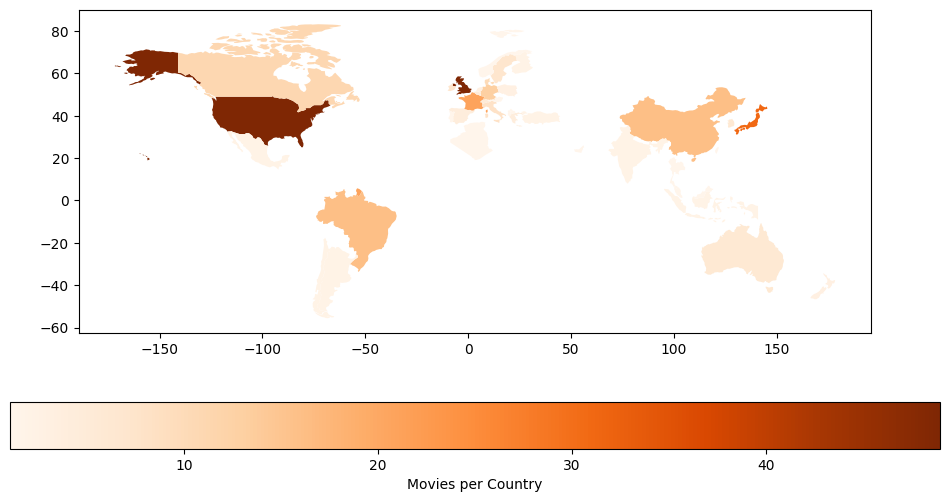

In [81]:
ig, ax = plt.subplots(figsize=(12,6))
my_cmap = []
test.plot(column='movie_count', cmap="Oranges", ax=ax, legend=True, legend_kwds={'label': "Movies per Country", 'orientation': "horizontal"})
